We study the following model:
$$
\mathsf{x} \sim \begin{cases}
\mathcal{N}(s \cdot \mu, I), & \text{with probability } 0.5,\\
\mathcal{N}(s \cdot -\mu, I), & \text{with probability } 0.5,
\end{cases}
$$
where $\mu \in \mathbb{R}^d$ is an arbitrary unit vector
and $s \geq 0$ is a scalar.

We assume $\mathsf{y} = \text{sign}(\mu^\top \mathsf{x})$.

Given iid samples $(x_1, y_1), \ldots, (x_n, y_n)$,
we learn classifier
$f(x) = \text{sign}(w^\top x)$,
where $w = 1 / n \cdot \sum_{i=1}^n y_ix_i$.

We analyze the scaling behavior of this learning algorithm
as we vary $d$ and $s$.

### Load libraries

In [10]:
import dataclasses
from typing import Collection, Optional

import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy.stats
from tqdm.auto import tqdm

plt.style.use('ggplot')

### Helper functions

In [19]:
def get_err(
    n_train: int,
    d: int,
    sep: float,
    approx_w0_thresh: Optional[int] = None,
) -> float:
    assert sep >= 0

    if approx_w0_thresh is not None and n_train > approx_w0_thresh:
        mean = scipy.stats.foldnorm.mean(sep)
        std = np.sqrt(scipy.stats.foldnorm.var(sep)) / np.sqrt(n_train)
        w0 = np.random.normal(loc=mean, scale=std)
        assert w0 > 0
    else:
        w0 = np.abs(sep + np.random.normal(size=n_train)).mean()

    # w1 = np.linalg.norm(np.random.normal(size=d - 1) / np.sqrt(n_train))
    w1 = np.sqrt(scipy.stats.chi2.rvs(d - 1) / n_train)

    norm = np.linalg.norm([w0, w1])
    w0 /= norm
    w1 /= norm

    def get_prob(m1: float, m2: float, c12: float) -> float:
        """
        Returns P(A > 0 and B <= 0) + P(A <= 0 and B > 0)
        assuming [A, B] ~ N([m1, m2], [[1, c12], [c12, 1]])
        """
        prob0: float = scipy.stats.multivariate_normal(
            mean=(-m1, m2),
            cov=((1, -c12), (-c12, 1)),  # type: ignore
        ).cdf(np.zeros(2))

        prob1: float = scipy.stats.multivariate_normal(
            mean=(m1, -m2),
            cov=((1, -c12), (-c12, 1)),  # type: ignore
        ).cdf(np.zeros(2))

        return prob0 + prob1

    return (get_prob(sep, sep * w0, w0) + get_prob(-sep, -sep * w0, w0)) / 2


### Scaling experiments

In [20]:
@dataclasses.dataclass
class ScalingResult:
    d: int
    sep: float
    n_trains: np.ndarray

    err_stack: np.ndarray

    def __post_init__(self):
        (n,) = self.n_trains.shape
        assert self.err_stack.shape[1] == n

    def plot(self, **kwargs):
        lo = np.quantile(self.err_stack, q=0.05, axis=0)
        mid = np.quantile(self.err_stack, q=0.5, axis=0)
        hi = np.quantile(self.err_stack, q=0.95, axis=0)

        p = plt.plot(self.n_trains, mid, label=f"sep={self.sep}")
        plt.fill_between(
            x=self.n_trains,
            y1=lo,
            y2=hi,
            alpha=0.25,
            color=p[0].get_color(),
        )


def run_exp(
    n_trains_raw: Collection[int],
    d: int,
    sep: float,
    n_trials: int = 100,
    use_tqdm: bool = False,
    **kwargs,
) -> ScalingResult:
    n_trains: np.ndarray = np.array(sorted(list(set(n_trains_raw))))

    err_stack = np.zeros((n_trials, len(n_trains)))

    for i in tqdm(range(n_trials)) if use_tqdm else range(n_trials):
        for j, n in enumerate(n_trains):
            err_stack[i, j] = get_err(n_train=n, d=d, sep=sep, **kwargs)

    return ScalingResult(d=d, sep=sep, n_trains=n_trains, err_stack=err_stack)

In [21]:
# Experiment results are stored here
RES: dict[tuple[int, int], ScalingResult] = {}
RES_APPROX: dict[tuple[int, int], ScalingResult] = {}

In [25]:
DS = [10, 100, 1000, 10_000, 100_000]
SEPS = [0, 1, 2, 3, 5, 6]

np.random.seed(0)
for d in tqdm(DS):
    for sep in tqdm(SEPS):
        key = (d, sep)
        if key not in RES:
            RES[key] = run_exp(
                n_trains_raw=
                list(range(2, 32))
                + list(range(32, 128, 4))
                + list(range(128, 1024, 32)) + [2**i for i in range(1, 20)],
                d=d,
                sep=sep,
                n_trials=50,
            )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
np.random.seed(0)
for d in tqdm(DS):
    for sep in tqdm(SEPS):
        key = (d, sep)
        if key not in RES_APPROX:
            RES_APPROX[key] = run_exp(
                n_trains_raw=
                list(range(2, 32))
                + list(range(32, 128, 4))
                + list(range(128, 1024, 32)) + [2**i for i in range(1, 25)],
                d=d,
                sep=sep,
                n_trials=50,
                approx_w0_thresh=10_000,
            )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

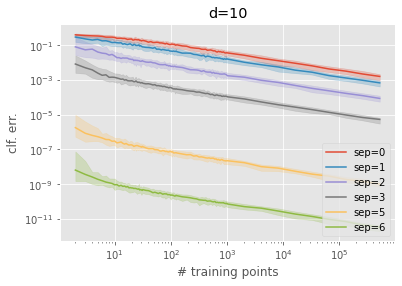

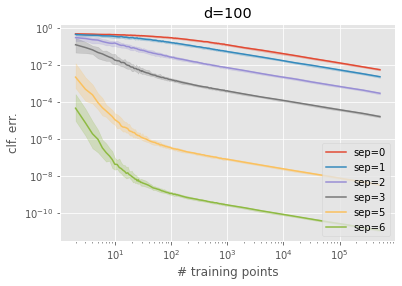

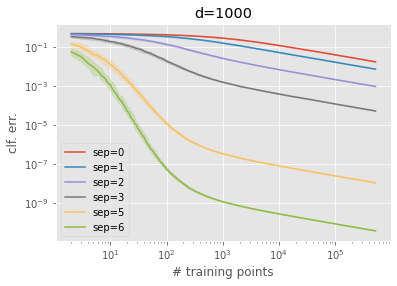

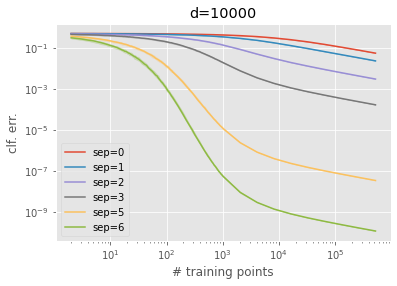

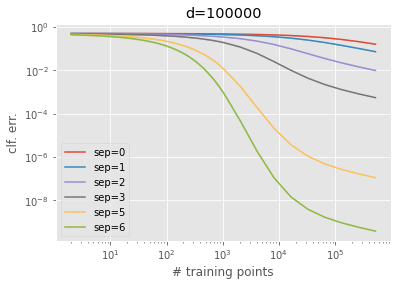

In [30]:
for d in DS:
    for sep in SEPS:
        RES[(d, sep)].plot()
    
    plt.title(f"{d=}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# training points")
    plt.ylabel("clf. err.")
    plt.legend();
    plt.show();

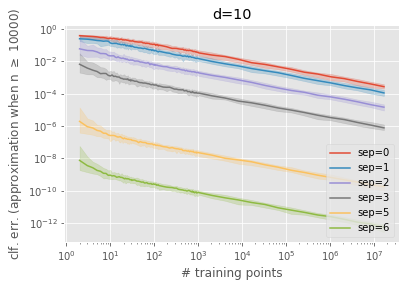

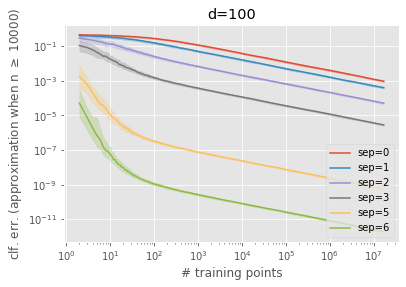

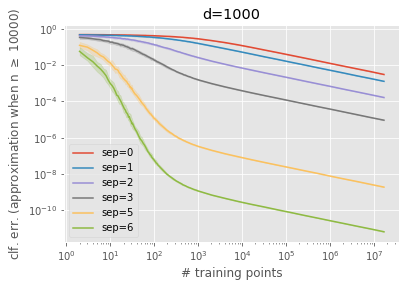

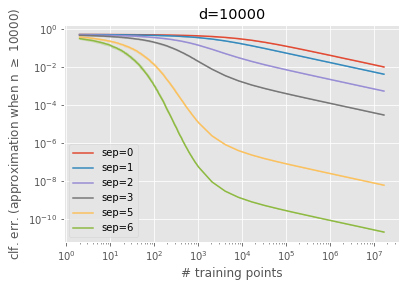

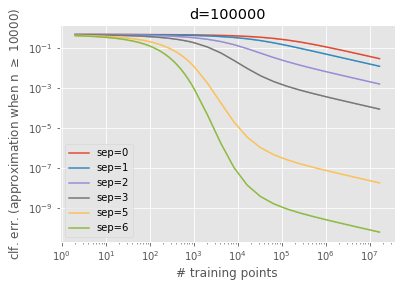

In [29]:
for d in DS:
    for sep in SEPS:
        RES_APPROX[(d, sep)].plot()
    
    plt.title(f"{d=}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# training points")
    plt.ylabel("clf. err. (approximation when n $\geq$ 10000)")
    plt.legend();
    plt.show();